<a href="https://colab.research.google.com/github/presentchris/AICourse/blob/main/pneumonia_prediction_2%ED%8C%80_DB%EB%94%94%EB%B9%84%EB%94%A5(%EC%B5%9C%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Chest-xray 사진을 사용하여 폐렴 여부 예측 프로그램 만들기]
1.데이터 가져오기 ( x_train[], y_train[] / x_val[], y_val[] / x_test[], y_text[] )
* 함수만들기 ( 이미지 회색조로 변경/resize 하기 - try~except적용 )

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#chest_xray.zip 데이터 셋 압축 해제
#import zipfile
#%cd /content/drive/MyDrive
#!unzip "chest_xray.zip"


In [ ]:
import os
os.listdir('/content/drive/MyDrive/chest_xray/')

['val', 'train', 'test']

In [ ]:
from PIL import Image
import numpy as np

base_path = '/content/drive/MyDrive/chest_xray/'

def load_data(folder_name):
    x = []
    y = []

    # Normal
    normal_images = os.listdir(os.path.join(base_path, folder_name, 'NORMAL'))
    for image_file in normal_images:
        try:
            image = Image.open(os.path.join(base_path, folder_name, 'NORMAL', image_file)).convert('L')
            image = image.resize((150, 150))
            x.append(np.array(image))
            y.append(0)  # 0 for Normal
        except Exception as e:
            print(f"Error processing NORMAL image {image_file}: {e}")

    # Pneumonia
    pneumonia_images = os.listdir(os.path.join(base_path, folder_name, 'PNEUMONIA'))
    for image_file in pneumonia_images:
        try:
            image = Image.open(os.path.join(base_path, folder_name, 'PNEUMONIA', image_file)).convert('L')
            image = image.resize((150, 150))
            x.append(np.array(image))
            y.append(1)  # 1 for Pneumonia
        except Exception as e:
            print(f"Error processing PNEUMONIA image {image_file}: {e}")

    return np.array(x), np.array(y)

x_train, y_train = load_data('train')
x_val, y_val = load_data('val')
x_test, y_test = load_data('test')


# from PIL import Image
# import numpy as np
# from pathlib import Path

# # 경로를 Path 객체로 설정
# base_path = Path('/content/drive/MyDrive/intel_AI/AI4FW023/chest_xray/')

# def load_data(folder_name):
#     x = []
#     y = []

#     # Normal 이미지 처리
#     normal_images = list((base_path / folder_name / 'NORMAL').iterdir())
#     for image_file in normal_images:
#         try:
#             image = Image.open(base_path / folder_name / 'NORMAL' / image_file.name).convert('L')
#             image = image.resize((150, 150))
#             x.append(np.array(image))
#             y.append(0)  # 0 for Normal
#         except Exception as e:
#             print(f"Error processing NORMAL image {image_file.name}: {e}")

#     # Pneumonia 이미지 처리
#     pneumonia_images = list((base_path / folder_name / 'PNEUMONIA').iterdir())
#     for image_file in pneumonia_images:
#         try:
#             image = Image.open(base_path / folder_name / 'PNEUMONIA' / image_file.name).convert('L')
#             image = image.resize((150, 150))
#             x.append(np.array(image))
#             y.append(1)  # 1 for Pneumonia
#         except Exception as e:
#             print(f"Error processing PNEUMONIA image {image_file.name}: {e}")

#     return np.array(x), np.array(y)

# x_train, y_train = load_data('train')
# x_val, y_val = load_data('val')
# x_test, y_test = load_data('test')


2.데이터 살펴보기
- shape 확인, matplotlib으로 이미지 확인하기

Training data shape: (5220, 150, 150)
Validation data shape: (16, 150, 150)
Test data shape: (624, 150, 150)


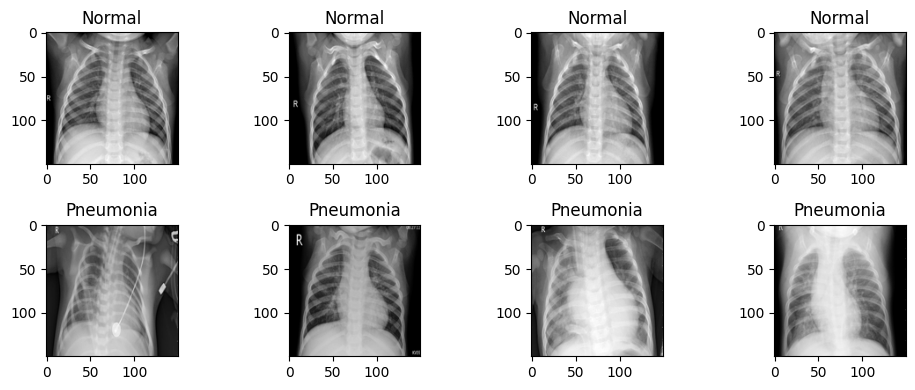

In [ ]:
import matplotlib.pyplot as plt

print(f"Training data shape: {np.array(x_train).shape}")
print(f"Validation data shape: {np.array(x_val).shape}")
print(f"Test data shape: {np.array(x_test).shape}")

# 샘플 이미지 시각화
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    if i < 4:
        plt.imshow(x_train[i], cmap='gray')
        plt.title('Normal')
    else:
        plt.imshow(x_train[i + len(x_train) // 2], cmap='gray')
        plt.title('Pneumonia')
plt.tight_layout()
plt.show()


3.데이터 정규화

In [ ]:
# 데이터 정규화
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

# 차원 확장 (Conv2D 레이어 입력을 위해)
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


4.데이터 증대 - 선택사항

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# 데이터 증대 설정
datagen = ImageDataGenerator(
    rotation_range=20,       # 이미지 회전 범위 최대 20도 회전
    width_shift_range=0.2,  # 수평 이동 범위 최대 20% 픽셀 만큼 이동
    height_shift_range=0.2, # 수직 이동 범위 최대 20% 픽셀 만큼 이동
    shear_range=0.2,        # 전단 변환 범위 이미지 늘리거나 압축 20%까지
    zoom_range=0.2,         # 확대/축소 범위 확대 축소 20%까지
    horizontal_flip=True,   # 좌우 반전 수평으로 무작위 변환
    fill_mode='nearest'     # 빈 영역 채우는 방식 , 가장 가까운 픽셀 값을 사용해서 채워준다.
)

5.모델 구성(CNN 모델) 및 컴파일, 학습

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#여러 층을 순차적으로 쌓는 방식의 모델로 정의
model = Sequential()
#32개의 필터를 사용하는데 각 필터의 크기는 3x3이고 활성화 함수는 relu사용, 입력 이미지는 150,150이며 1이므로 회색조
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
#맵의 크기를 줄이고 계산량을 감소시켜주는 MaxPooling 수행
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))  # 25%의 뉴런을 비활성화
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))  # 25%의 뉴런을 비활성화
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))  # 25%의 뉴런을 비활성화
#2D합성곱 층의 출력을 1D로 평탄화>완전 연결층에 입력을 전달해준다.
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # 50%의 뉴런을 비활성화
#최종 출력 층으로 이진 분류 작업을 수행하기 때문에 출력 뉴런은 이 된다. 시그모이드 활성화함수 사용
model.add(Dense(1, activation='sigmoid'))
#이진 교차 엔트로피 사용, adam옵티마이저 사용(가중치 업데이트 수행), 정확도 측정
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

'''
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SeparableConv2D, BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
'''



"\nfrom keras.models import Sequential\nfrom keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SeparableConv2D, BatchNormalization, Dropout\n\nmodel = Sequential()\nmodel.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))\nmodel.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))\nmodel.add(MaxPooling2D(pool_size = (2, 2)))\nmodel.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))\nmodel.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size = (2, 2)))\nmodel.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))\nmodel.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size = (2,

In [ ]:
#history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# 데이터 증대를 적용하여 모델 학습
# datagen.flow()를 사용하여 학습 데이터에 데이터 증대를 적용
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
164/164 [==============================] - 25s 77ms/step - loss: 0.5682 - accuracy: 0.7374 - val_loss: 0.6888 - val_accuracy: 0.5625
Epoch 2/10
164/164 [==============================] - 13s 78ms/step - loss: 0.4148 - accuracy: 0.8067 - val_loss: 0.5261 - val_accuracy: 0.8750
Epoch 3/10
164/164 [==============================] - 13s 81ms/step - loss: 0.3225 - accuracy: 0.8557 - val_loss: 0.5888 - val_accuracy: 0.7500
Epoch 4/10
164/164 [==============================] - 13s 81ms/step - loss: 0.2791 - accuracy: 0.8776 - val_loss: 0.7739 - val_accuracy: 0.6250
Epoch 5/10
164/164 [==============================] - 13s 78ms/step - loss: 0.2620 - accuracy: 0.8877 - val_loss: 0.8105 - val_accuracy: 0.6875
Epoch 6/10
164/164 [==============================] - 13s 78ms/step - loss: 0.2610 - accuracy: 0.8875 - val_loss: 0.6053 - val_accuracy: 0.8125
Epoch 7/10
164/164 [==============================] - 13s 76ms/step - loss: 0.2285 - accuracy: 0.9031 - val_loss: 0.7285 - val_accuracy:

6.모델 평가

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


20/20 [==============================] - 0s 9ms/step - loss: 0.4363 - accuracy: 0.7981
Test accuracy: 0.7981
Test loss: 0.4363


7.모델 훈련 분석 - 훈련과정 'Training & Validation Accuracy/ loss 그래프 그리기

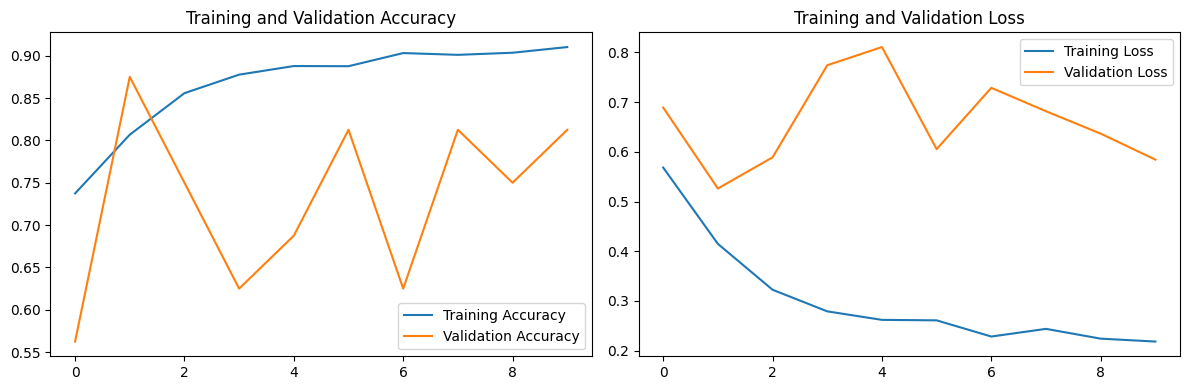

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


8.모델 예측 - confusion matrix , classification report 출력

20/20 [==============================] - 0s 8ms/step


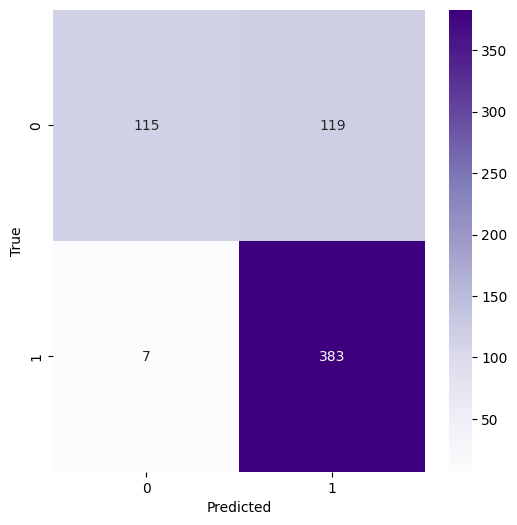

              precision    recall  f1-score   support

      NORMAL       0.94      0.49      0.65       234
   PNEUMONIA       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 모델 예측
y_pred = model.predict(x_test)
#y_pred을 기반으로 예측 확률이 0.5보다 크면 1, 아니면 0으로
y_pred_classes = [1 if prob > 0.5 else 0 for prob in y_pred]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
#정밀도, 재현율, F1 점수 및 지원 카운트를 포함하여 모델의 분류 성능 요약
report = classification_report(y_test, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA'])
print(report)


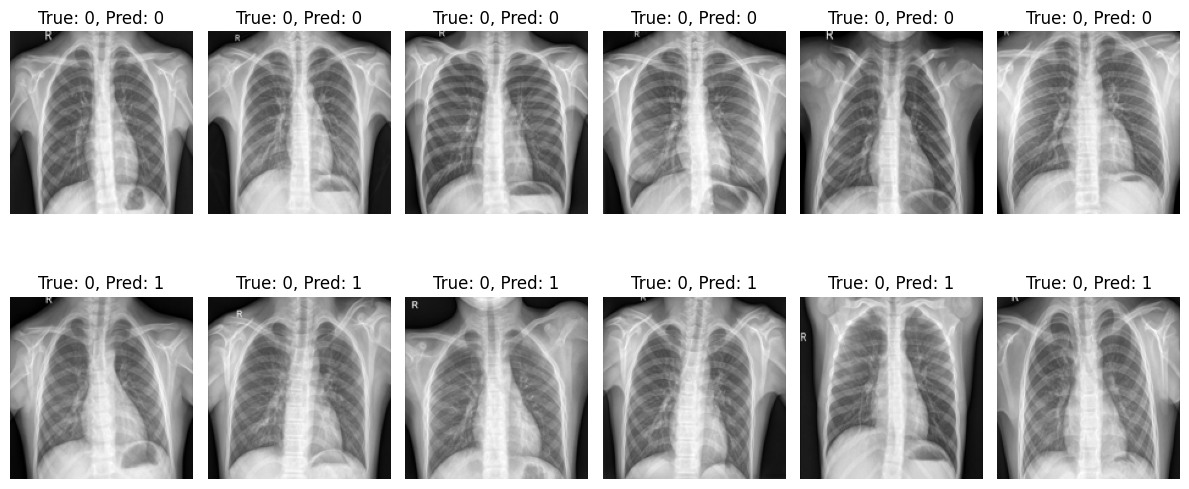

In [ ]:
correctly_classified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred_classes)) if true == pred]
incorrectly_classified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred_classes)) if true != pred]

# 올바르게 예측된 샘플 시각화
plt.figure(figsize=(12, 6))
for i, index in enumerate(correctly_classified_indices[:6]):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x_test[index].reshape(150, 150), cmap='gray')
    plt.title(f"True: {y_test[index]}, Pred: {y_pred_classes[index]}")
    plt.axis('off')

# 잘못 예측된 샘플 시각화
for i, index in enumerate(incorrectly_classified_indices[:6]):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x_test[index].reshape(150, 150), cmap='gray')
    plt.title(f"True: {y_test[index]}, Pred: {y_pred_classes[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
